- find 50 most common fragments in each subpocket
- cluster these fragments using Butina clustering and show largest clusters

In [28]:
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
# clustering
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path_to_library = '/home/paula/Masterarbeit/FragmentLibrary/'

# list of folders for each subpocket
subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X']
folders = [path_to_library+subpocket for subpocket in subpockets]

In [14]:
# read data

data = pd.DataFrame()

# iterate over subpockets
for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]
    
    file = folder+'/'+subpocket+'.sdf' 
    df = pd.DataFrame()
    suppl = Chem.SDMolSupplier(file, removeHs=False)
        
    fragments = []
    smiles = []
    groups = []

    for frag in suppl:
        # remove dummy atoms from fragments and create smiles
        du = Chem.MolFromSmiles('*')
        h = Chem.MolFromSmiles('[H]', sanitize=False)
        fixed_frag = AllChem.ReplaceSubstructs(frag, du, h, replaceAll=True)[0]
        fixed_frag = Chem.RemoveHs(fixed_frag)
        # smiles for comparing fragments
        s = Chem.MolToSmiles(fixed_frag)
        smiles.append(s)
        # 2D coordinates
        tmp = AllChem.Compute2DCoords(fixed_frag)
        fragments.append(fixed_frag)
        # kinase group
        groups.append(frag.GetProp('group'))
     
    df['smiles'] = smiles
    df['fragment'] = fragments
    df['subpocket'] = subpocket
    df['group'] = groups
    
    data = data.append(df)
    
data = data.reset_index(drop=True)
data.shape

(7486, 5)

In [21]:
df_AP = data[data.subpocket=='AP']
df_FP = data[data.subpocket=='FP']
df_SE = data[data.subpocket=='SE']
df_GA = data[data.subpocket=='GA']
df_B1 = data[data.subpocket=='B1']
df_B2 = data[data.subpocket=='B2']

Functions for clustering:

In [17]:
# Calculate distance matrix for fingerprint list
def Tanimoto_distance_matrix(fp_list):
    fp_list = list(fp_list)
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix

In [16]:
# Input: Fingerprints and a threshold for the clustering
def ClusterFps(fps, cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matr = Tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

In [134]:
cutoff = 0.6

## Adenine pocket:

In [183]:
frag_counts = df_AP.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]

In [184]:
fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 50
Threshold:  0.6
# clusters:  18
# clusters with only 1 compound:  9


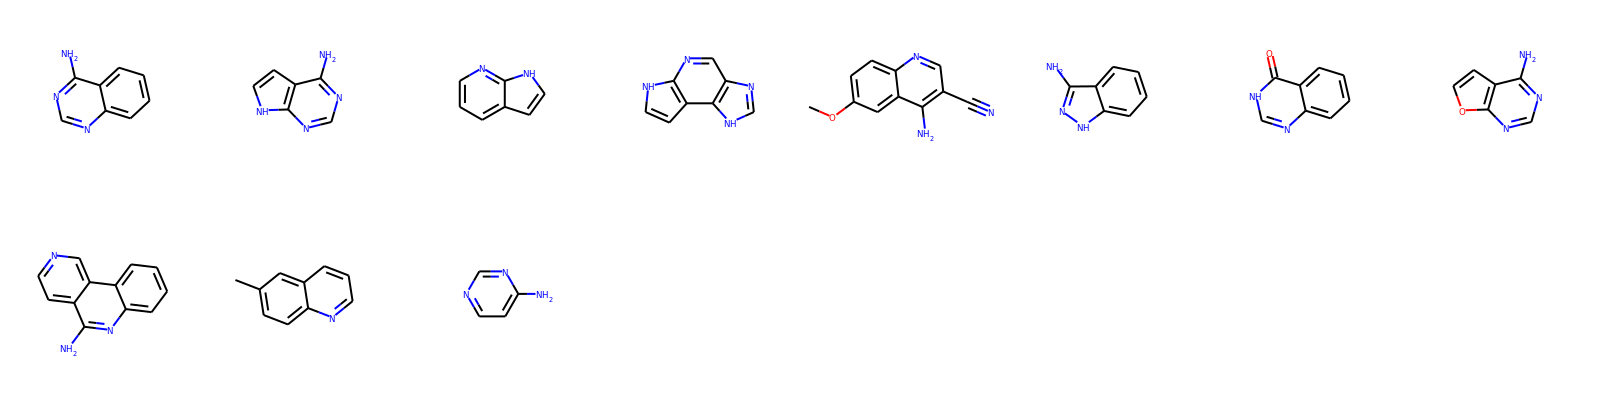

In [185]:
cluster_mols = [mols[i] for i in clusters[0]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

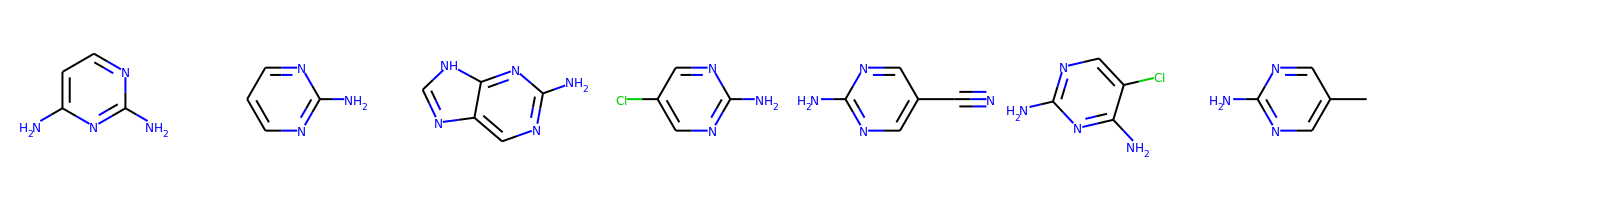

In [157]:
cluster_mols = [mols[i] for i in clusters[1]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

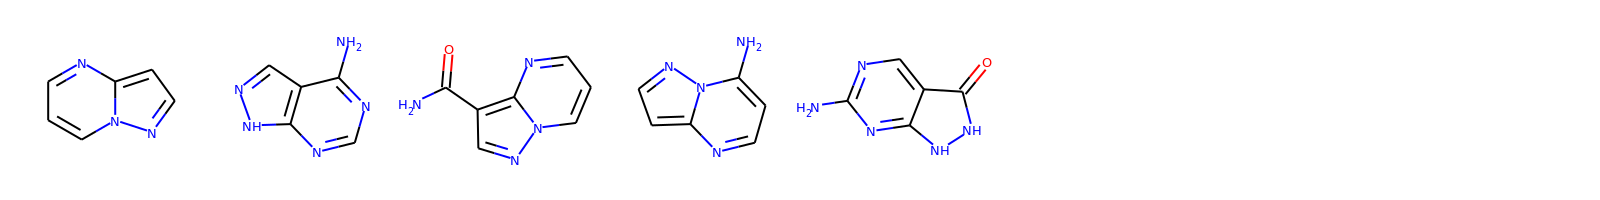

In [158]:
cluster_mols = [mols[i] for i in clusters[2]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

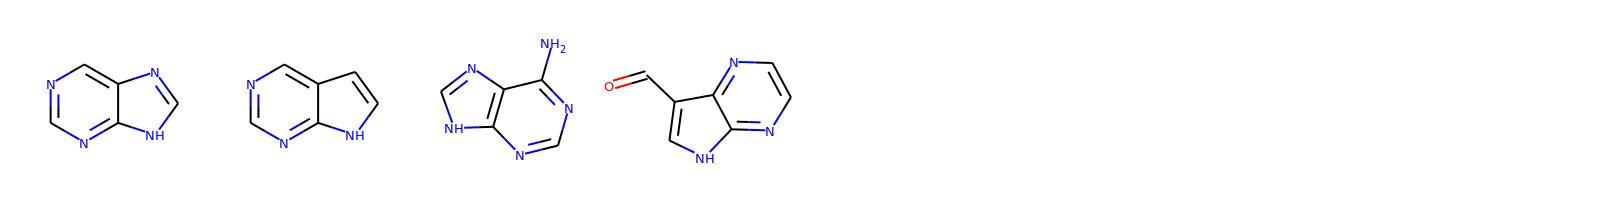

In [159]:
cluster_mols = [mols[i] for i in clusters[3]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

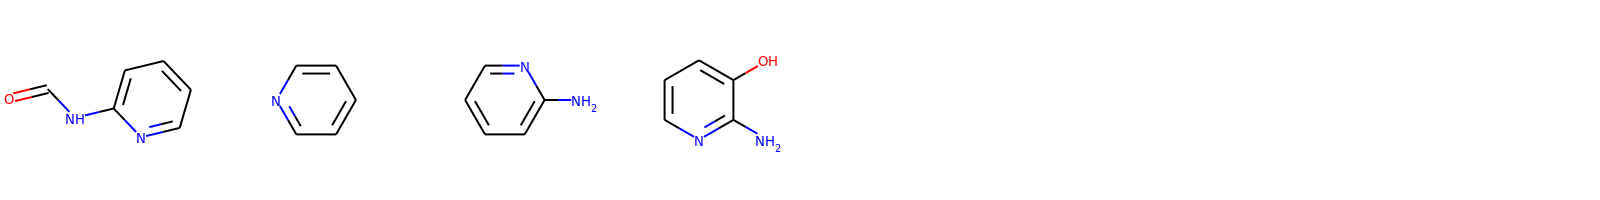

In [160]:
cluster_mols = [mols[i] for i in clusters[4]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

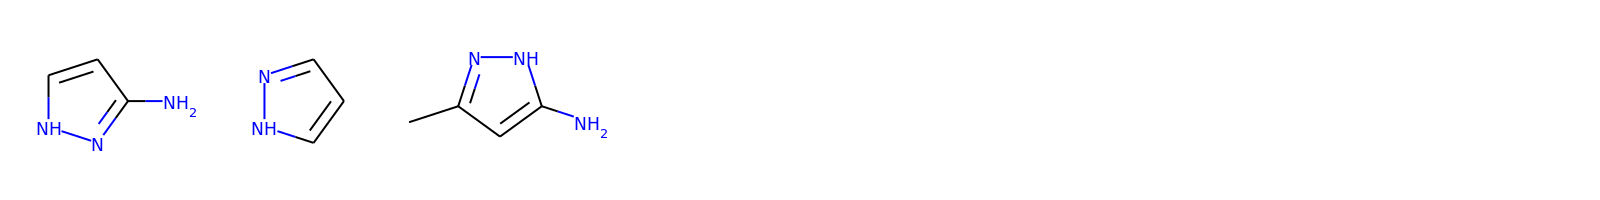

In [161]:
cluster_mols = [mols[i] for i in clusters[5]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

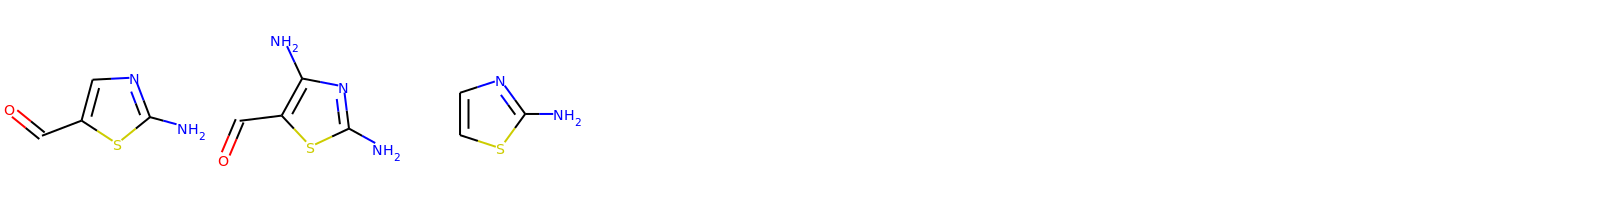

In [162]:
cluster_mols = [mols[i] for i in clusters[6]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

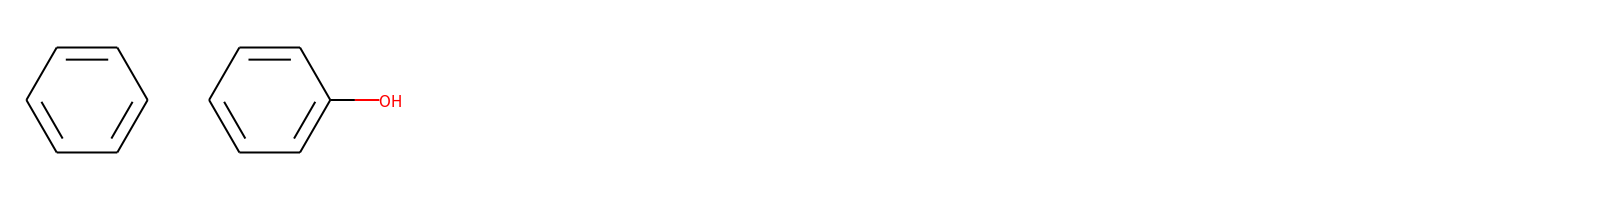

In [163]:
cluster_mols = [mols[i] for i in clusters[7]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

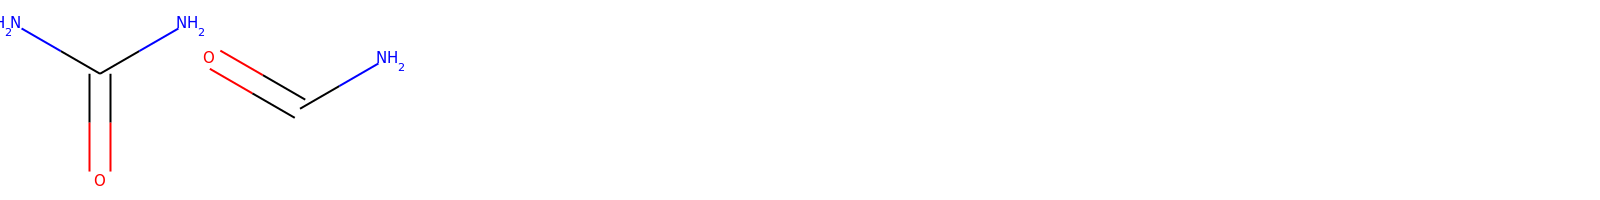

In [164]:
cluster_mols = [mols[i] for i in clusters[8]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

## Front pocket:

In [186]:
frag_counts = df_FP.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]

In [187]:
fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 50
Threshold:  0.6
# clusters:  22
# clusters with only 1 compound:  8


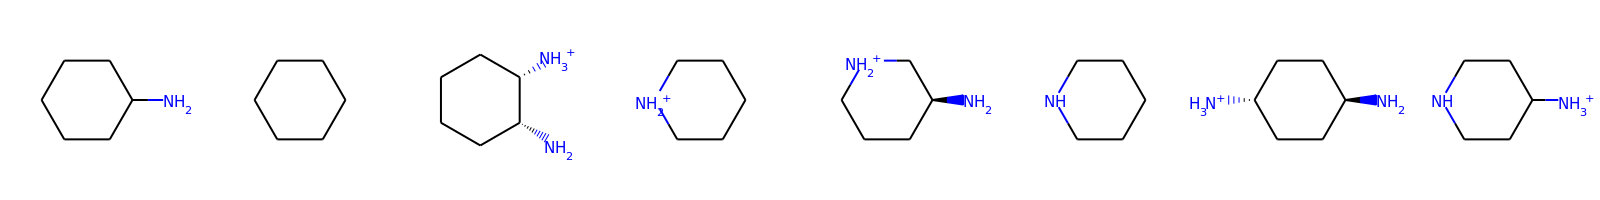

In [188]:
cluster_mols = [mols[i] for i in clusters[0]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

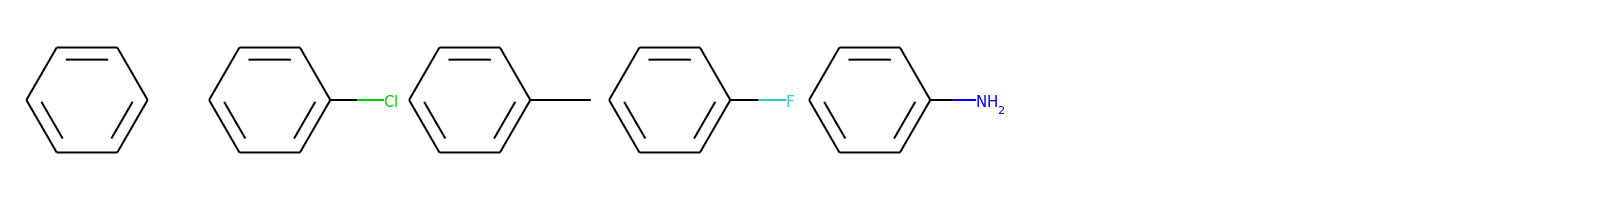

In [189]:
cluster_mols = [mols[i] for i in clusters[1]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

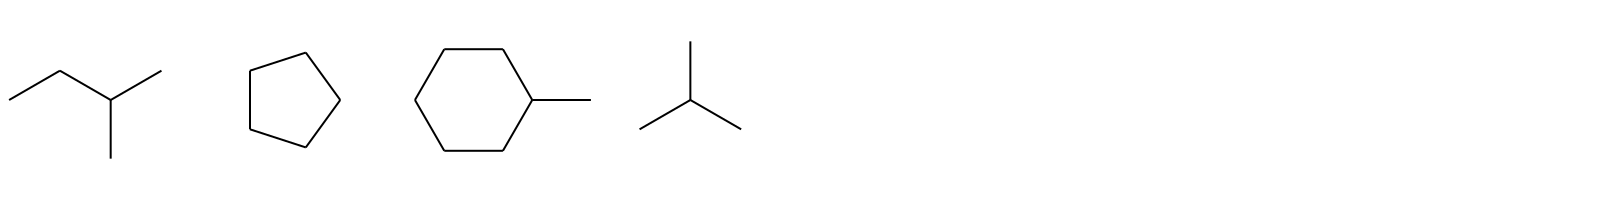

In [190]:
cluster_mols = [mols[i] for i in clusters[2]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

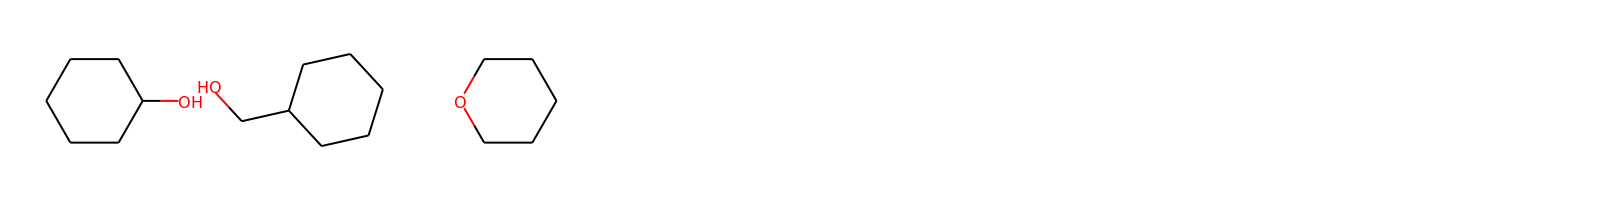

In [191]:
cluster_mols = [mols[i] for i in clusters[3]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

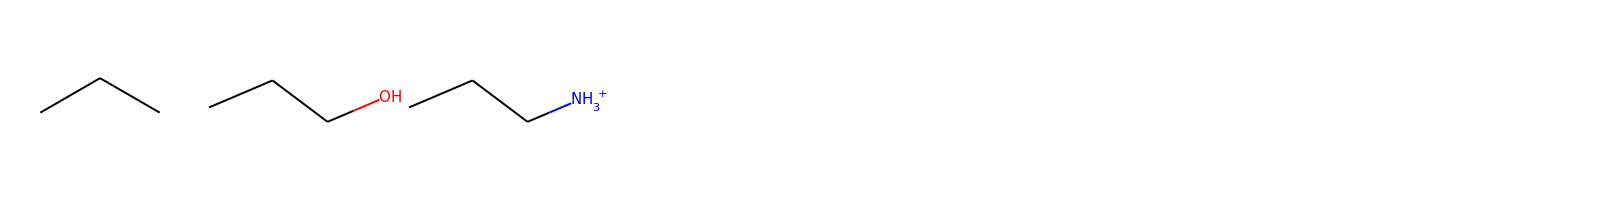

In [192]:
cluster_mols = [mols[i] for i in clusters[4]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

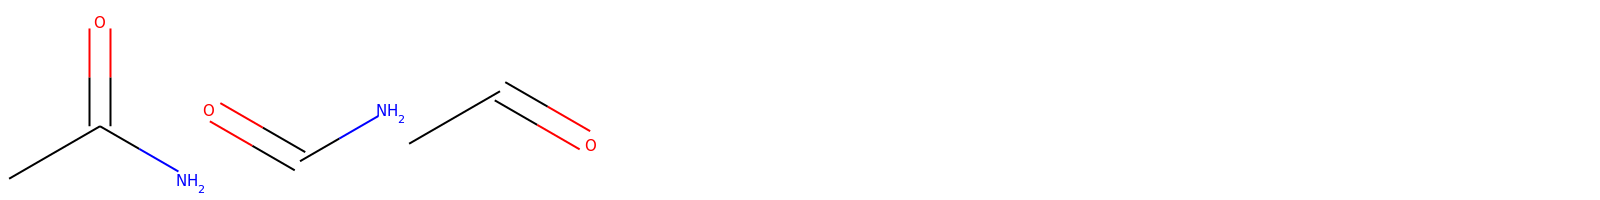

In [193]:
cluster_mols = [mols[i] for i in clusters[5]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

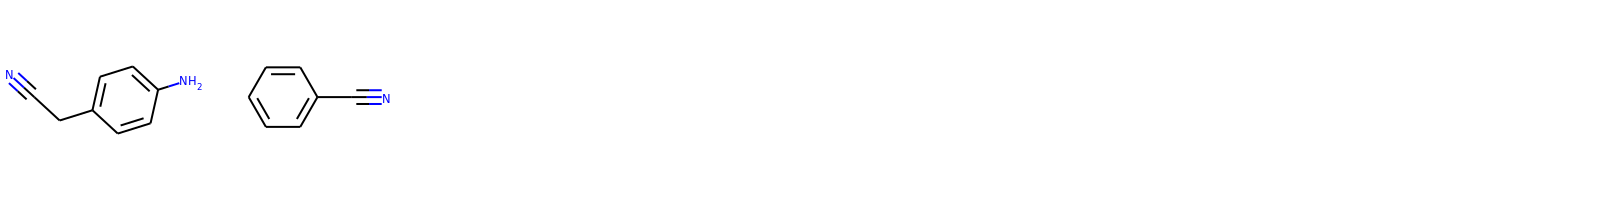

In [194]:
cluster_mols = [mols[i] for i in clusters[6]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

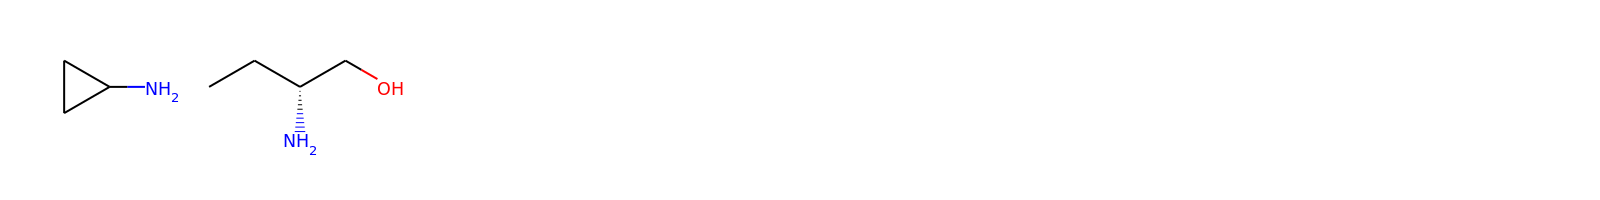

In [195]:
cluster_mols = [mols[i] for i in clusters[7]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

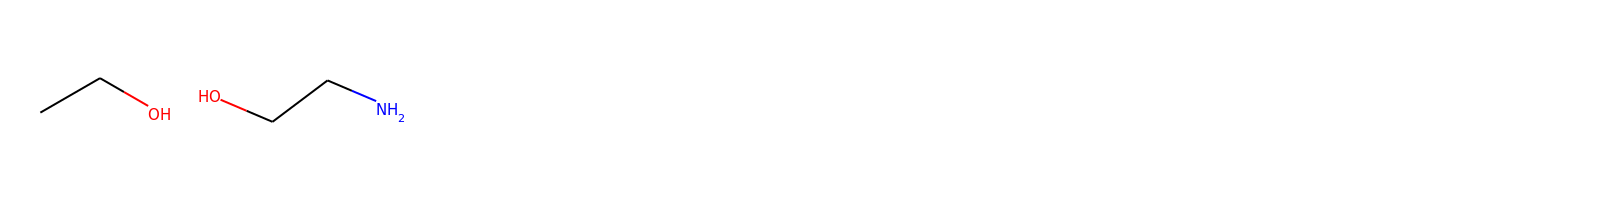

In [196]:
cluster_mols = [mols[i] for i in clusters[8]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

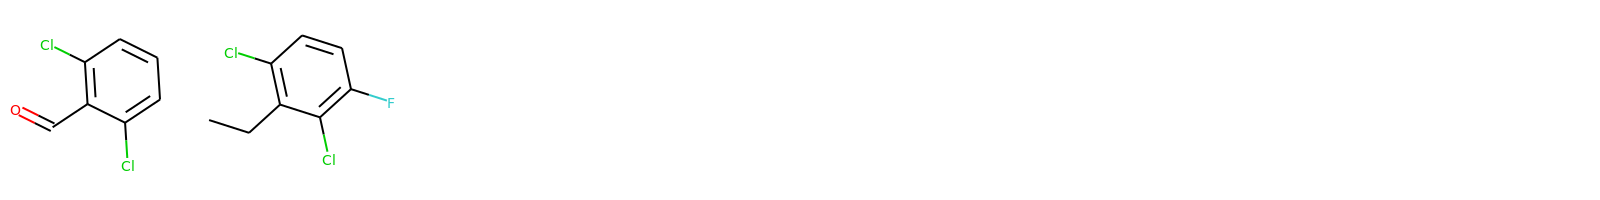

In [197]:
cluster_mols = [mols[i] for i in clusters[9]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

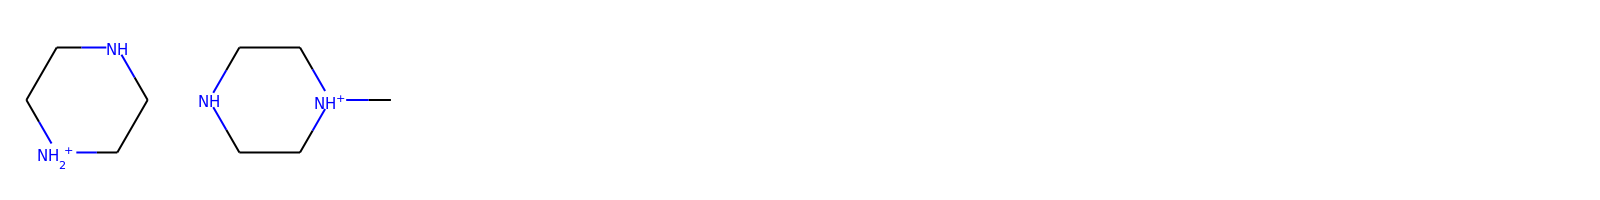

In [198]:
cluster_mols = [mols[i] for i in clusters[10]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

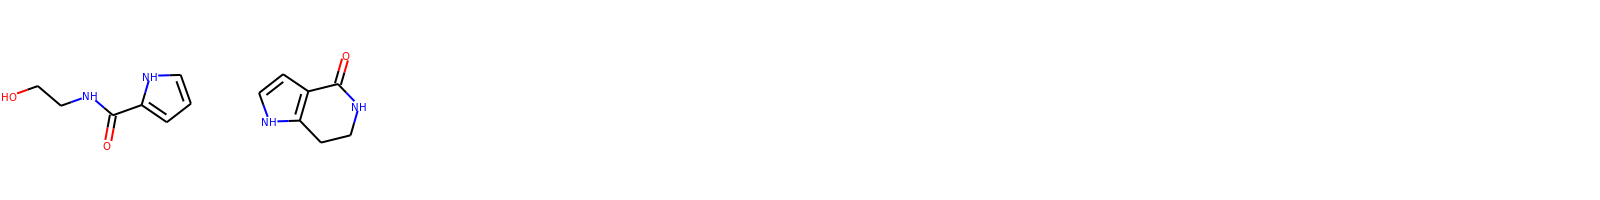

In [199]:
cluster_mols = [mols[i] for i in clusters[11]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

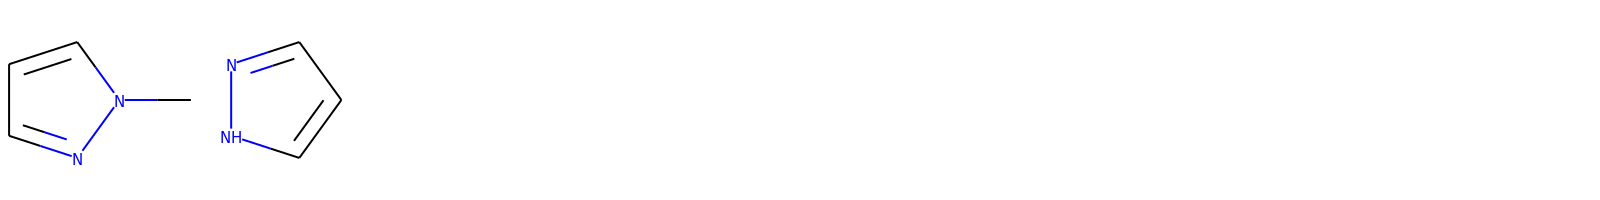

In [200]:
cluster_mols = [mols[i] for i in clusters[12]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

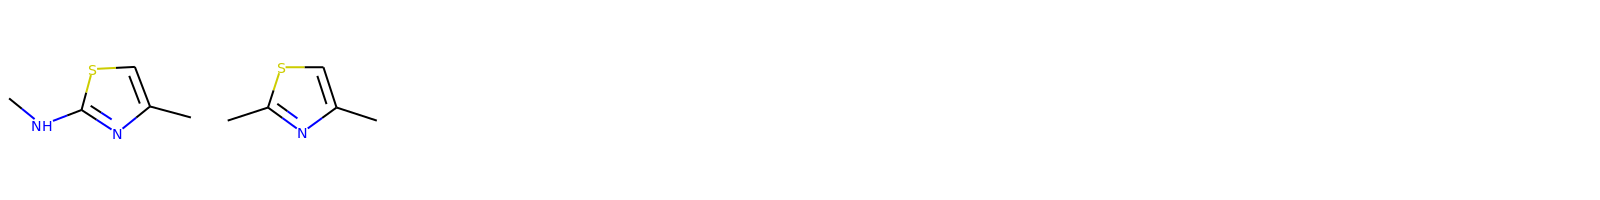

In [201]:
cluster_mols = [mols[i] for i in clusters[13]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

## Solvent-exposed pocket:

In [214]:
frag_counts = df_SE.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]

fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 50
Threshold:  0.6
# clusters:  23
# clusters with only 1 compound:  11


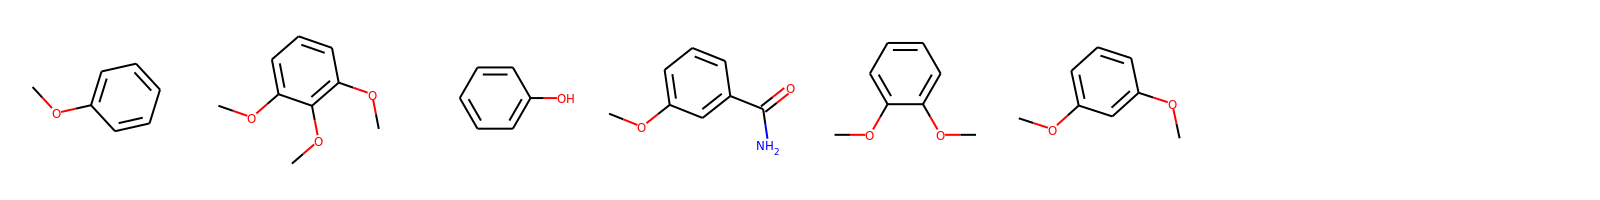

In [215]:
cluster_mols = [mols[i] for i in clusters[0]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

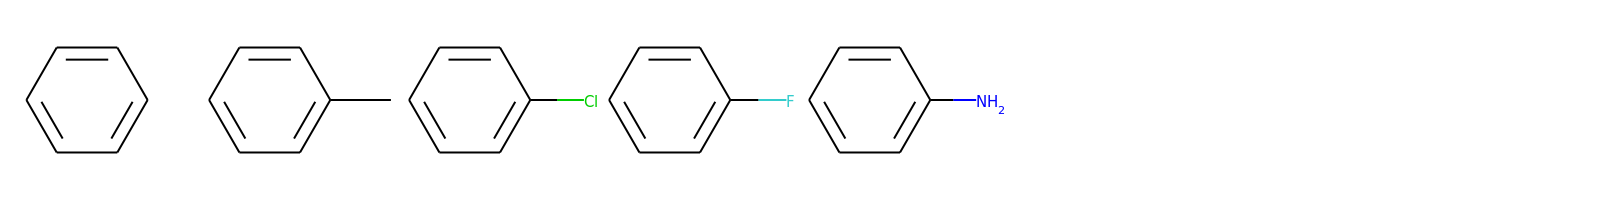

In [216]:
cluster_mols = [mols[i] for i in clusters[1]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

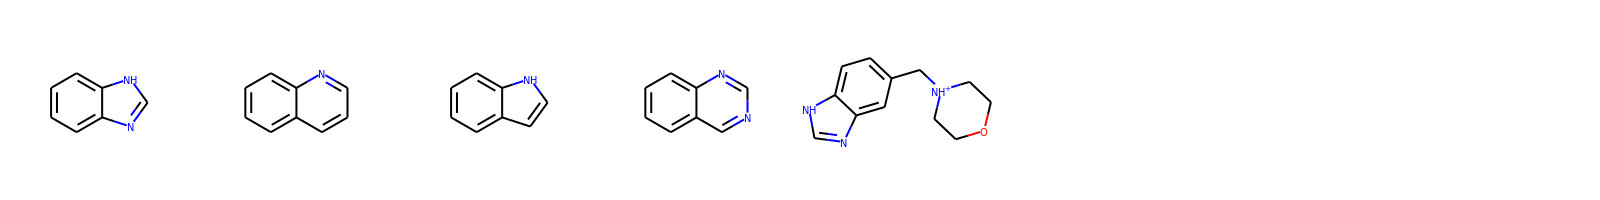

In [217]:
cluster_mols = [mols[i] for i in clusters[2]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

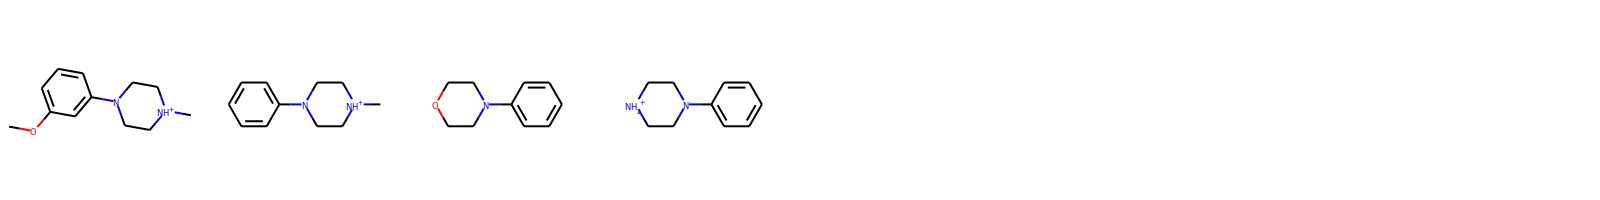

In [218]:
cluster_mols = [mols[i] for i in clusters[3]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

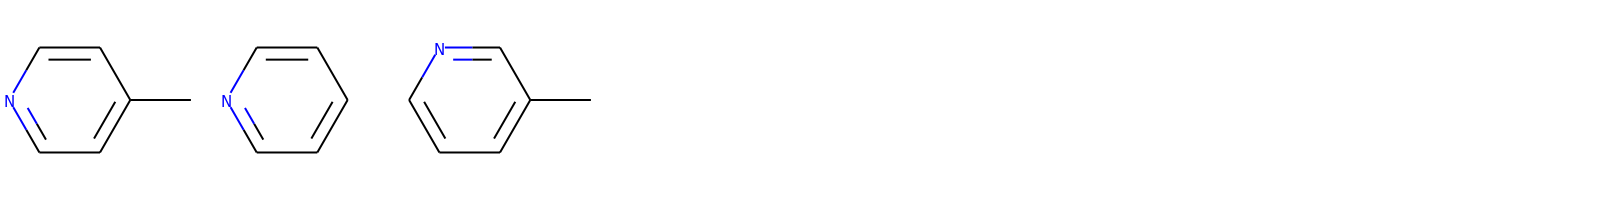

In [219]:
cluster_mols = [mols[i] for i in clusters[4]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

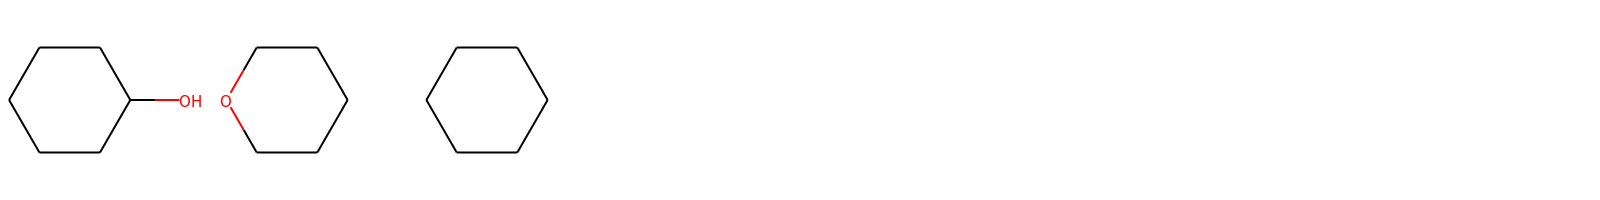

In [220]:
cluster_mols = [mols[i] for i in clusters[5]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

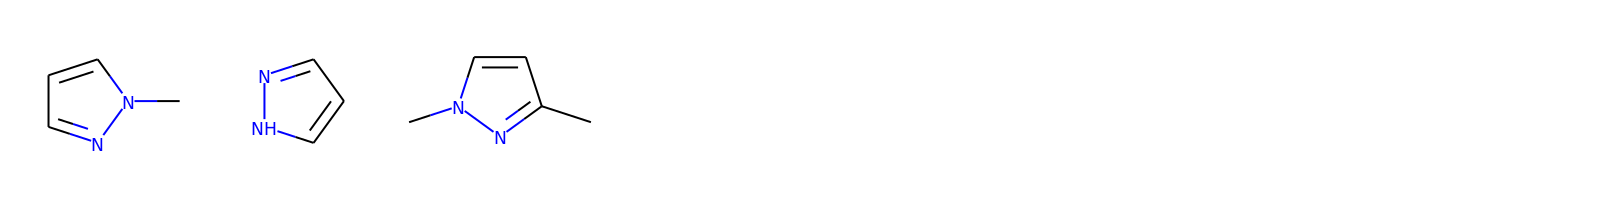

In [221]:
cluster_mols = [mols[i] for i in clusters[6]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

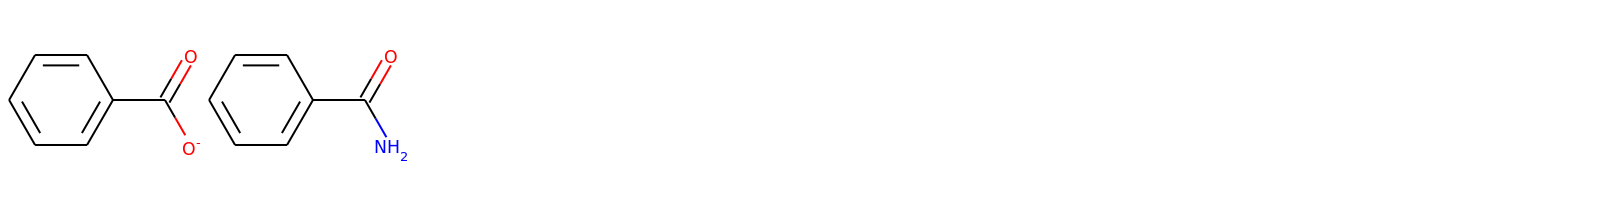

In [222]:
cluster_mols = [mols[i] for i in clusters[7]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

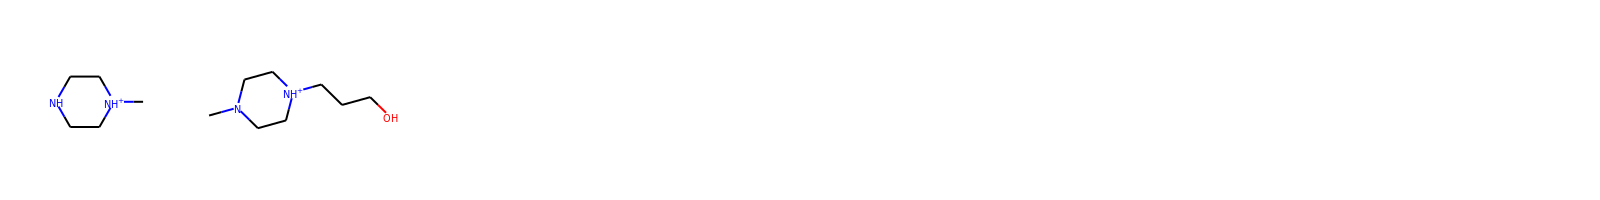

In [223]:
cluster_mols = [mols[i] for i in clusters[8]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

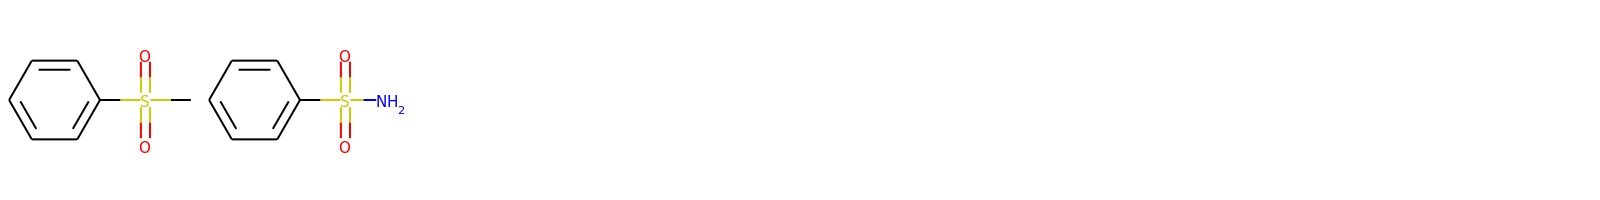

In [224]:
cluster_mols = [mols[i] for i in clusters[9]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

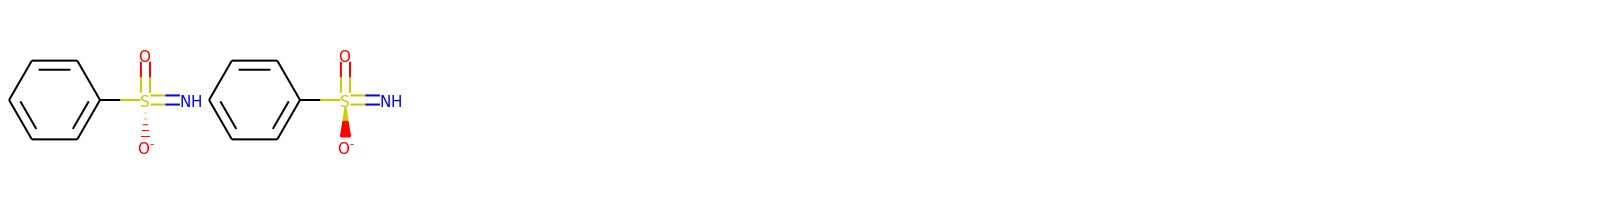

In [225]:
cluster_mols = [mols[i] for i in clusters[10]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

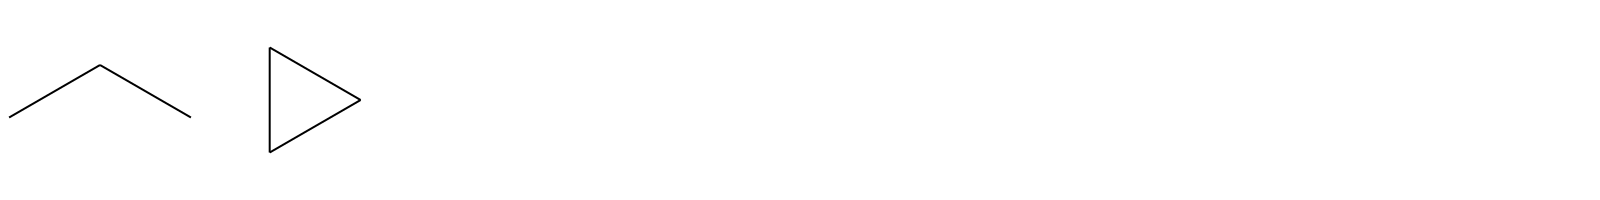

In [226]:
cluster_mols = [mols[i] for i in clusters[11]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

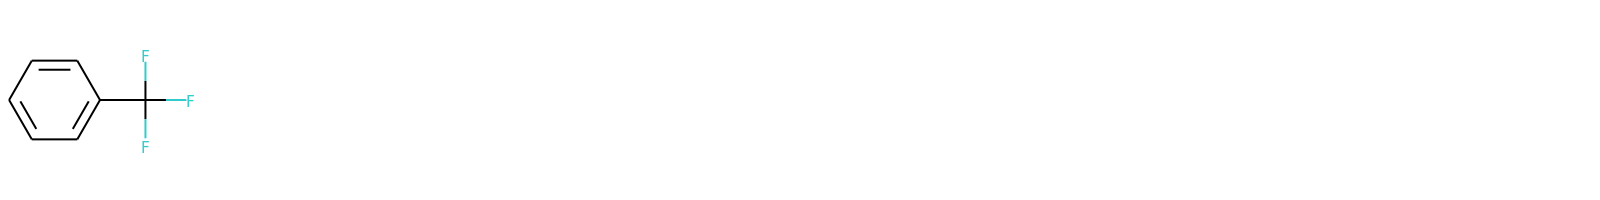

In [227]:
cluster_mols = [mols[i] for i in clusters[12]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

## Gate area:

In [203]:
frag_counts = df_GA.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]

fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 50
Threshold:  0.6
# clusters:  20
# clusters with only 1 compound:  11


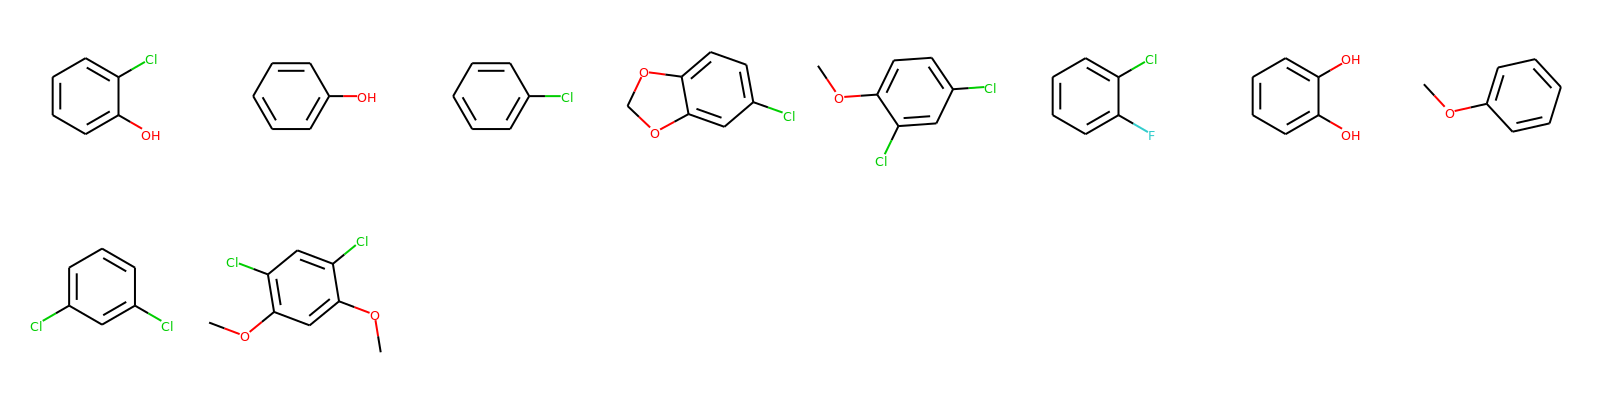

In [204]:
cluster_mols = [mols[i] for i in clusters[0]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

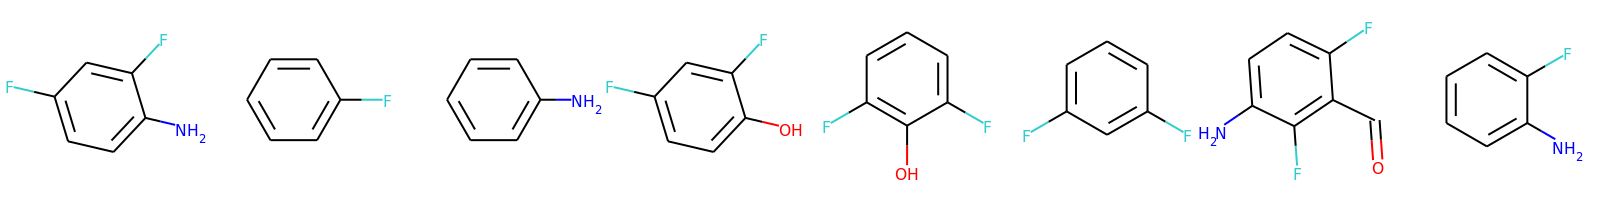

In [205]:
cluster_mols = [mols[i] for i in clusters[1]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

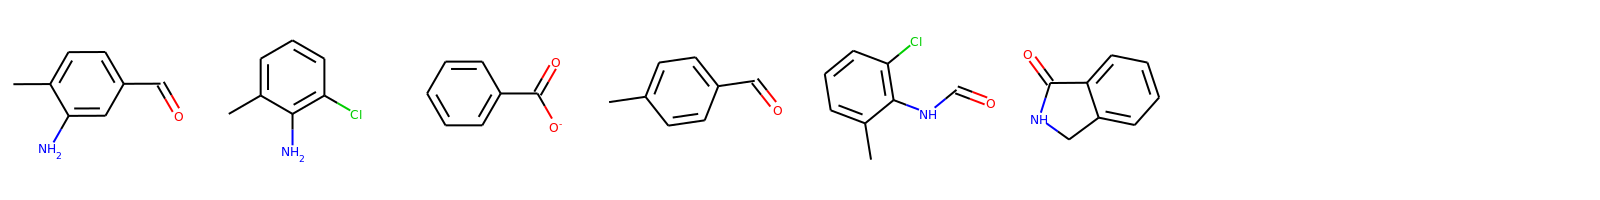

In [206]:
cluster_mols = [mols[i] for i in clusters[2]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

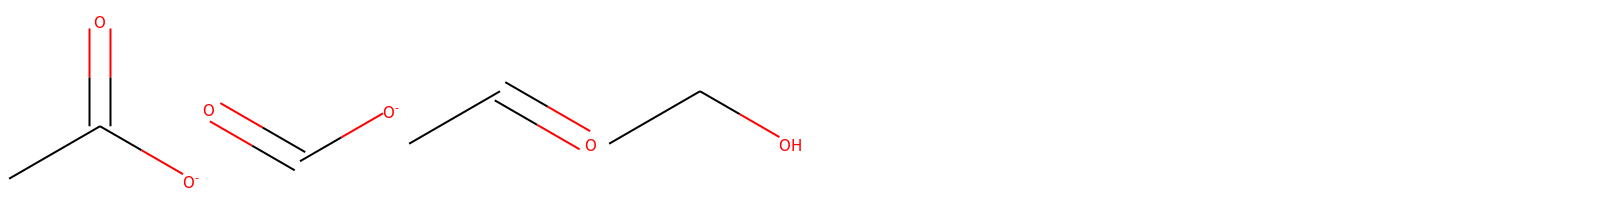

In [207]:
cluster_mols = [mols[i] for i in clusters[3]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

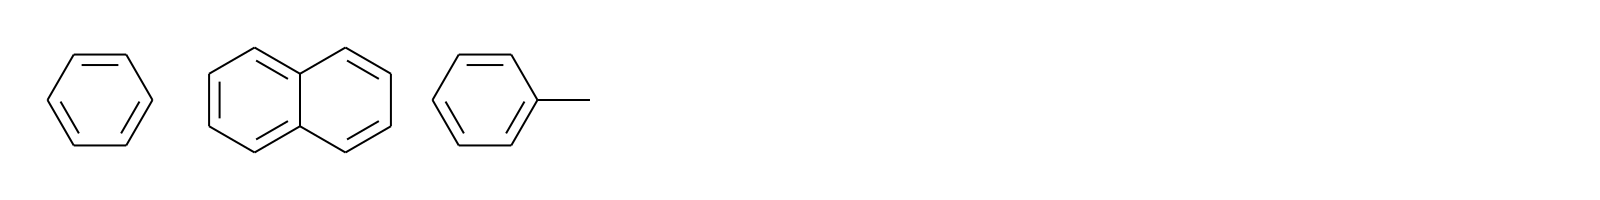

In [208]:
cluster_mols = [mols[i] for i in clusters[4]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

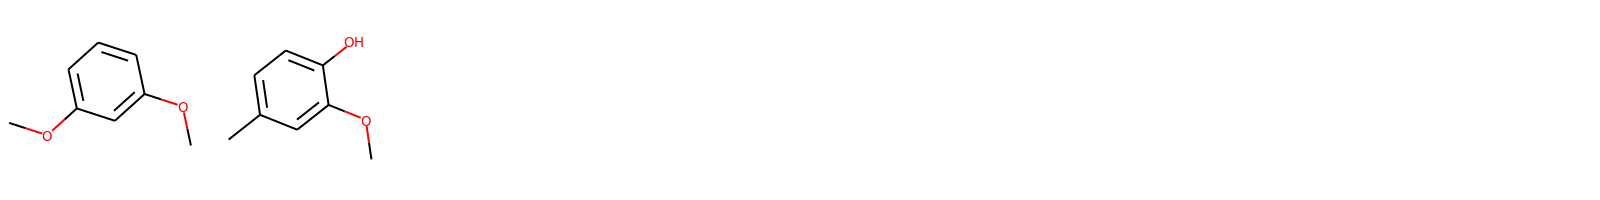

In [209]:
cluster_mols = [mols[i] for i in clusters[5]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

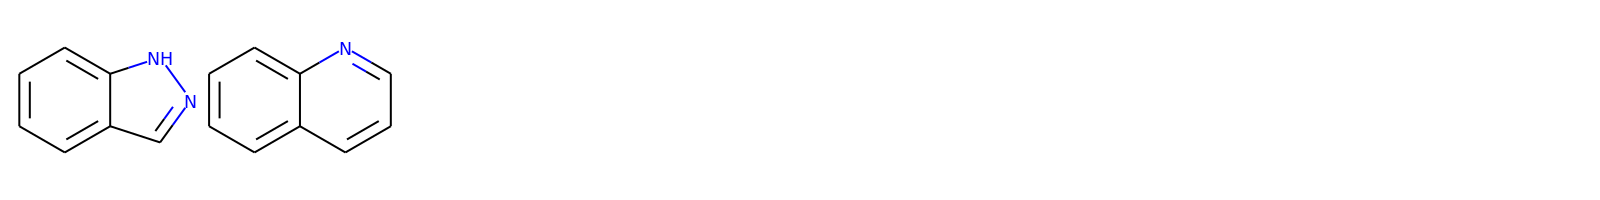

In [210]:
cluster_mols = [mols[i] for i in clusters[6]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

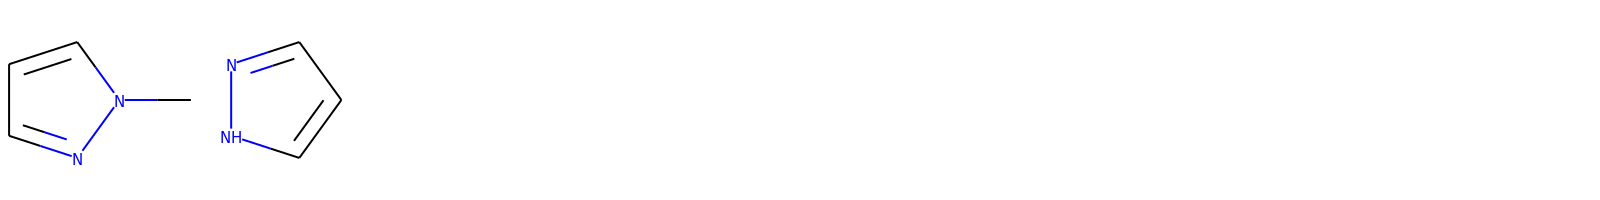

In [211]:
cluster_mols = [mols[i] for i in clusters[7]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

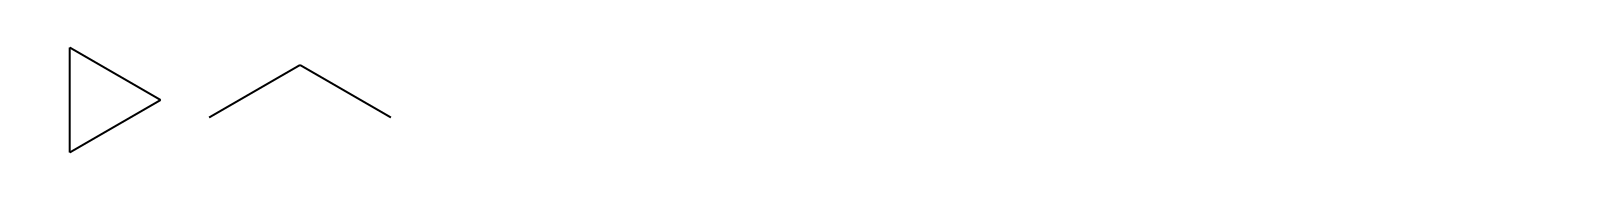

In [212]:
cluster_mols = [mols[i] for i in clusters[8]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

## Back pocket I:

In [250]:
frag_counts = df_B1.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]

fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 42
Threshold:  0.6
# clusters:  25
# clusters with only 1 compound:  17


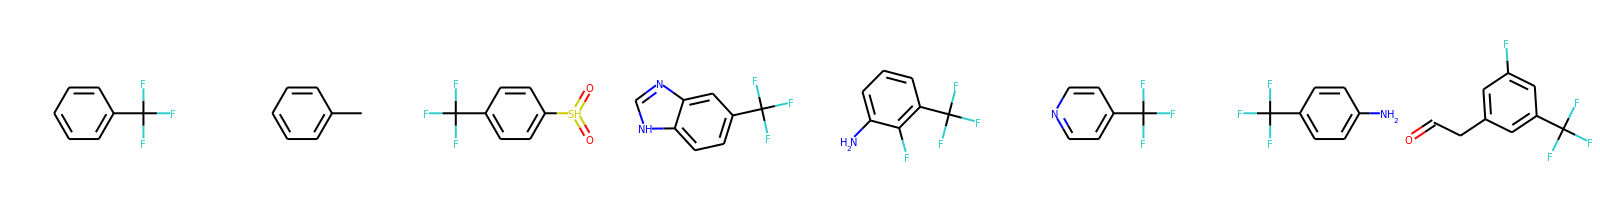

In [251]:
cluster_mols = [mols[i] for i in clusters[0]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

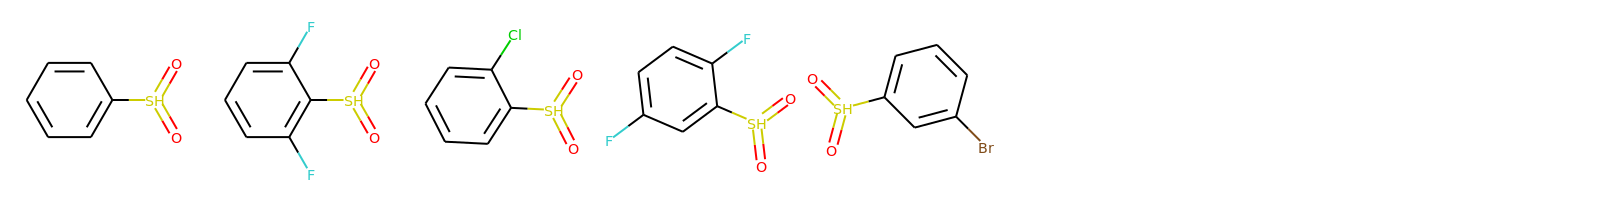

In [252]:
cluster_mols = [mols[i] for i in clusters[1]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

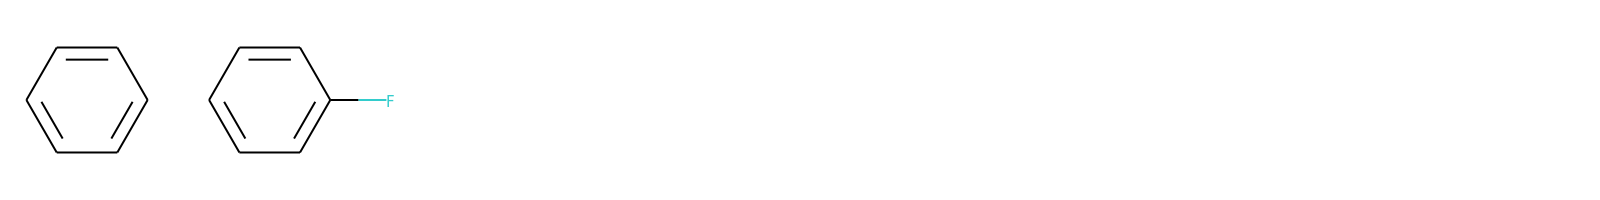

In [253]:
cluster_mols = [mols[i] for i in clusters[2]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

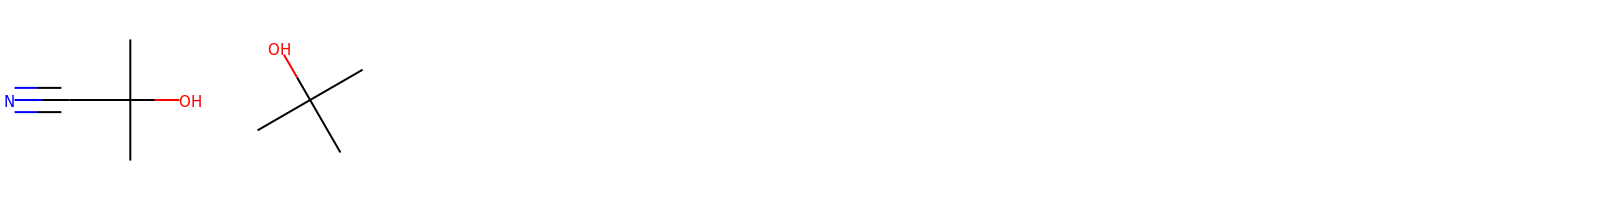

In [254]:
cluster_mols = [mols[i] for i in clusters[3]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

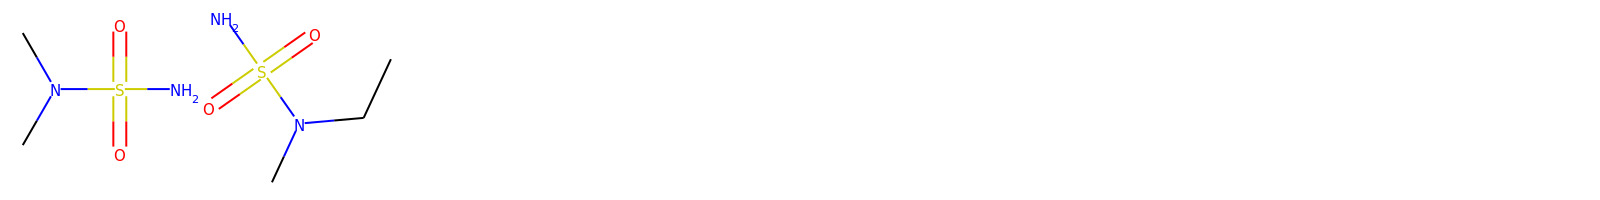

In [255]:
cluster_mols = [mols[i] for i in clusters[4]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

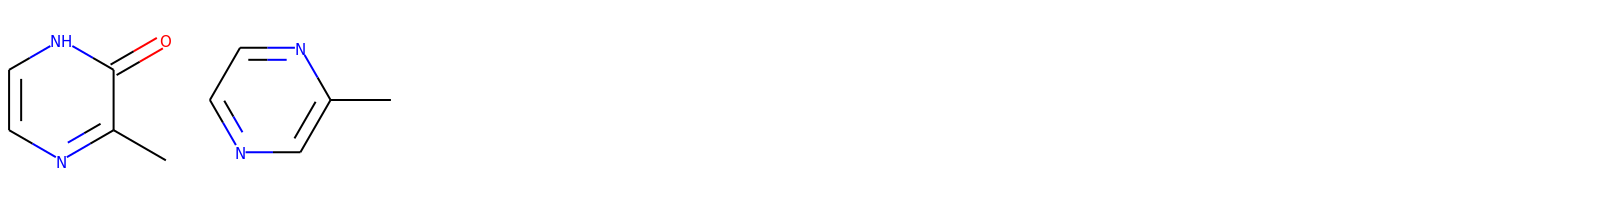

In [256]:
cluster_mols = [mols[i] for i in clusters[5]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

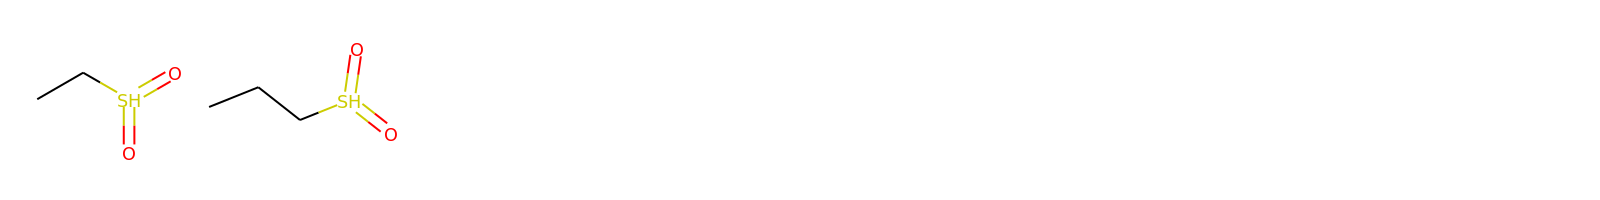

In [257]:
cluster_mols = [mols[i] for i in clusters[6]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

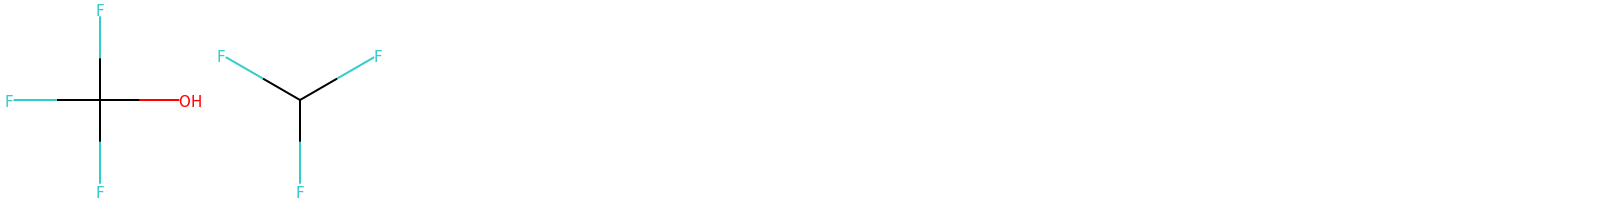

In [258]:
cluster_mols = [mols[i] for i in clusters[7]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

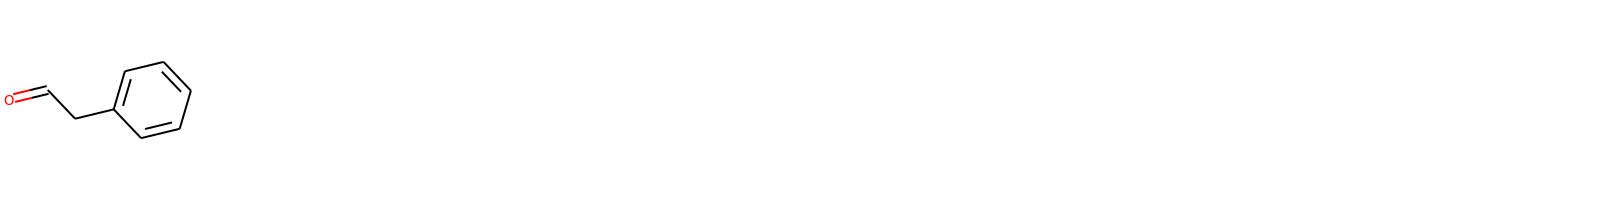

In [259]:
cluster_mols = [mols[i] for i in clusters[8]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

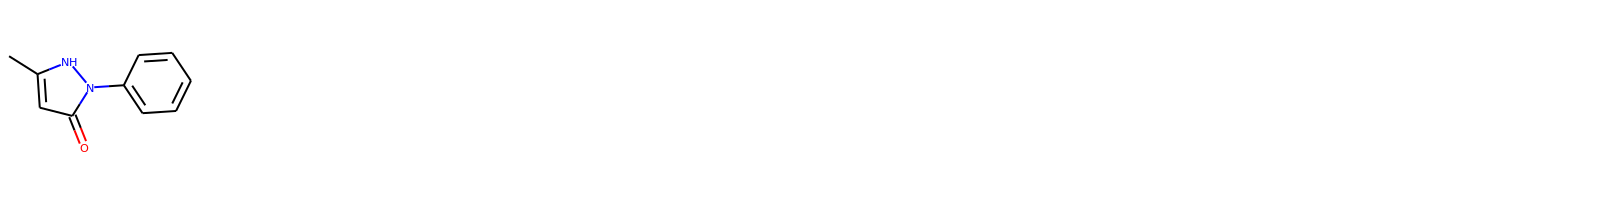

In [260]:
cluster_mols = [mols[i] for i in clusters[9]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

## Back pocket II:

In [261]:
frag_counts = df_B2.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]

fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 43
Threshold:  0.6
# clusters:  30
# clusters with only 1 compound:  24


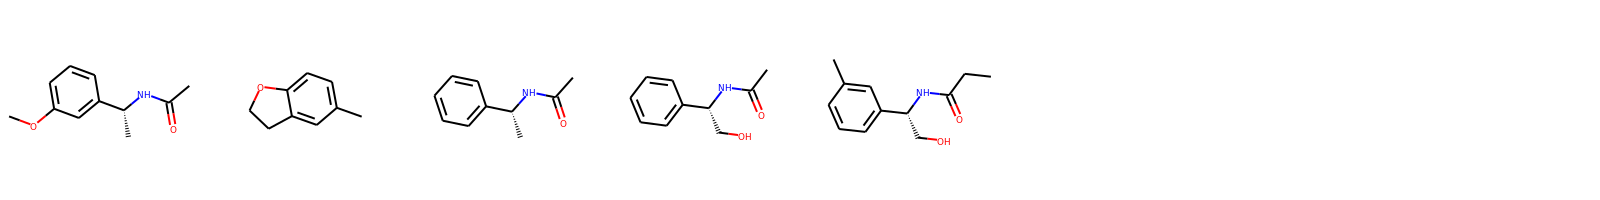

In [262]:
cluster_mols = [mols[i] for i in clusters[0]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

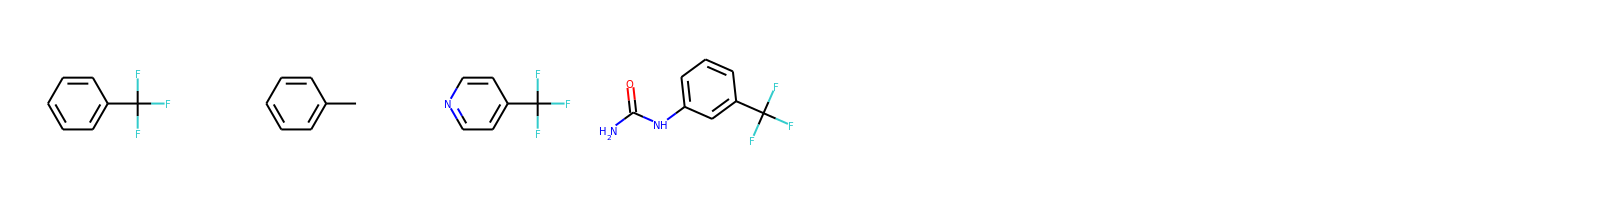

In [263]:
cluster_mols = [mols[i] for i in clusters[1]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

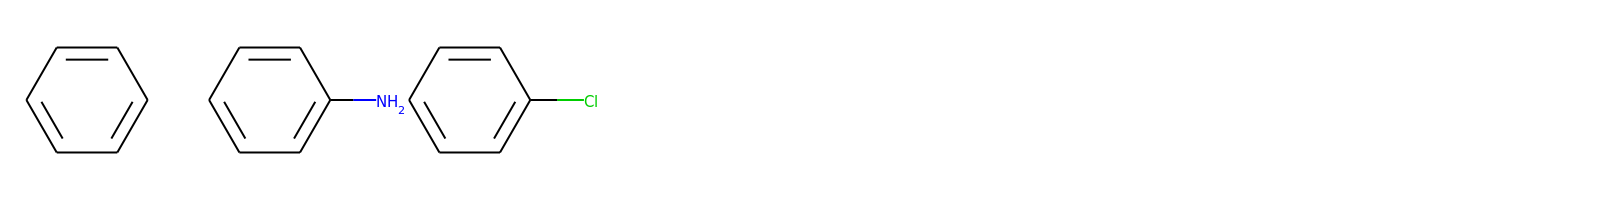

In [264]:
cluster_mols = [mols[i] for i in clusters[2]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

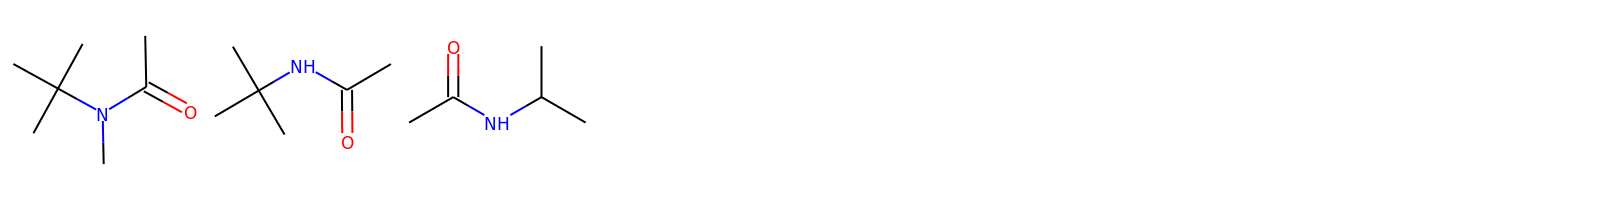

In [265]:
cluster_mols = [mols[i] for i in clusters[3]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

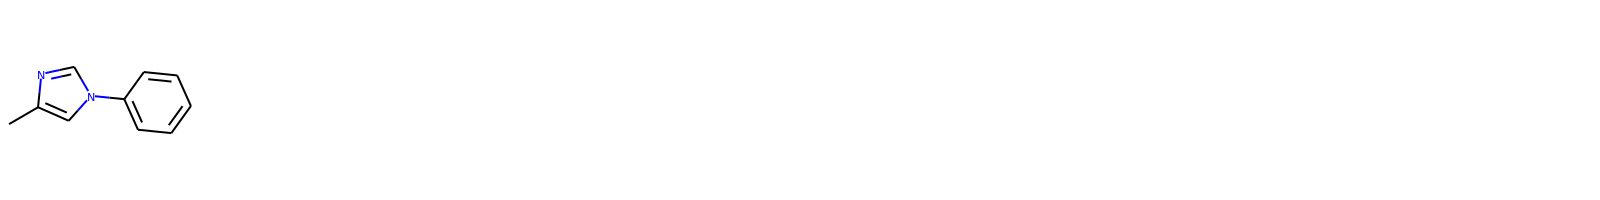

In [266]:
cluster_mols = [mols[i] for i in clusters[8]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)

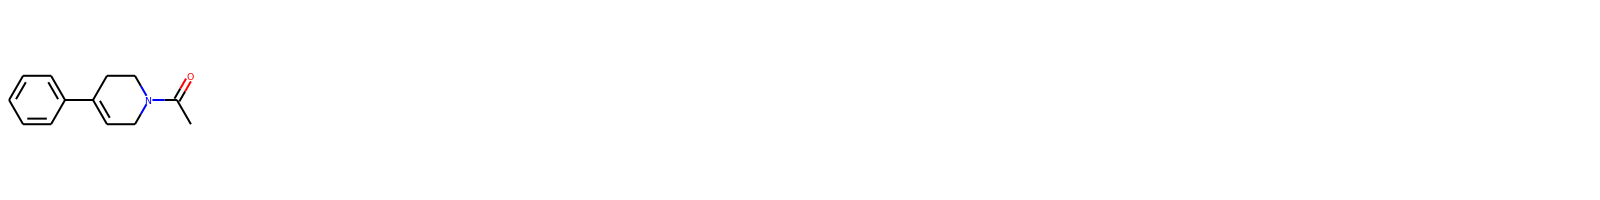

In [267]:
cluster_mols = [mols[i] for i in clusters[9]]
Draw.MolsToGridImage(cluster_mols,  molsPerRow=8)